# About Dataset
### Context

Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.

### Content

##### Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

### Gerekli Kütüphanelerin Eklenmesi

In [125]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_squared_log_error,r2_score

from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from flaml import AutoML

In [126]:
from pandas.io.parsers import read_csv

df = read_csv("insurance.csv")

In [127]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [129]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [130]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Keşifsel Veri Analizi 

In [131]:
df["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [132]:
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

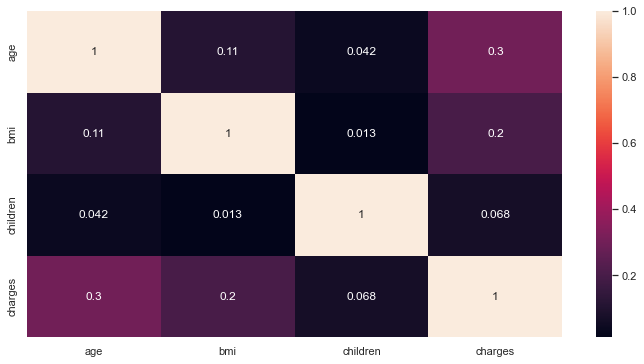

In [133]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True);

In [134]:
def corr_Vars(data):
   corr = data.corr()
   mask = np.triu(np.ones_like(corr))
   f, ax = plt.subplots(figsize=(11, 9))
   cmap = "YlGnBu"

# Draw the heatmap with the mask and correct aspect ratio
   sns.heatmap(
      corr,
      mask=mask,
      cmap=cmap,
      center=0,
      square=False,
      linewidths=0.5,
      cbar_kws={"shrink": 0.9},
             )

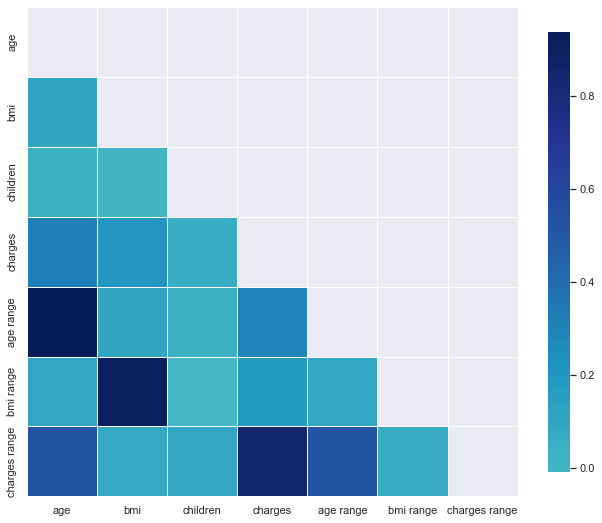

In [188]:
corr_Vars(df)

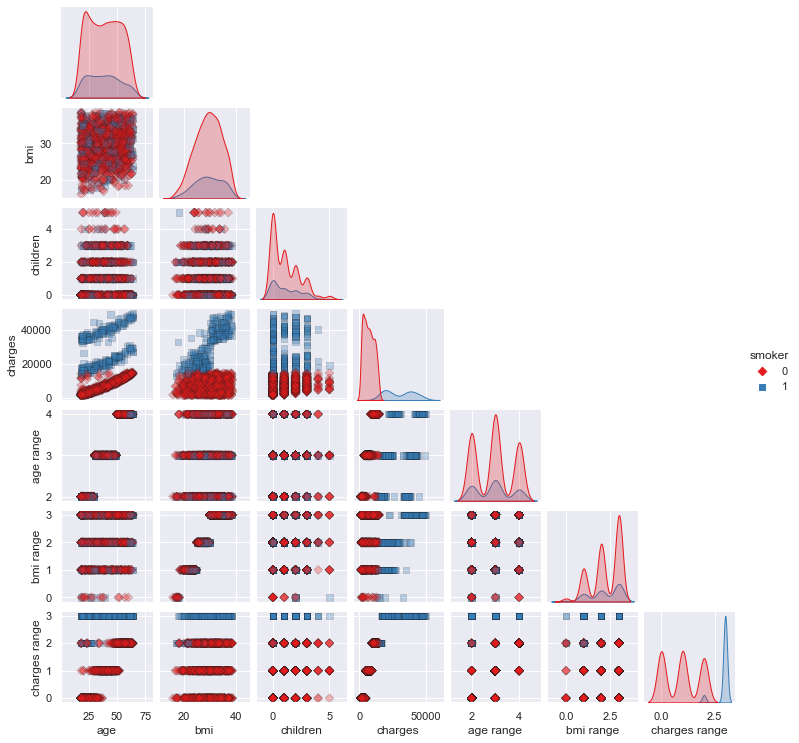

In [189]:
sns.pairplot(data=df, height=1.5, hue="smoker",
             palette="Set1",plot_kws = {'alpha': 0.3, 's': 40, 'edgecolor': 'k'}, markers=["D", "s"],
             corner=True);

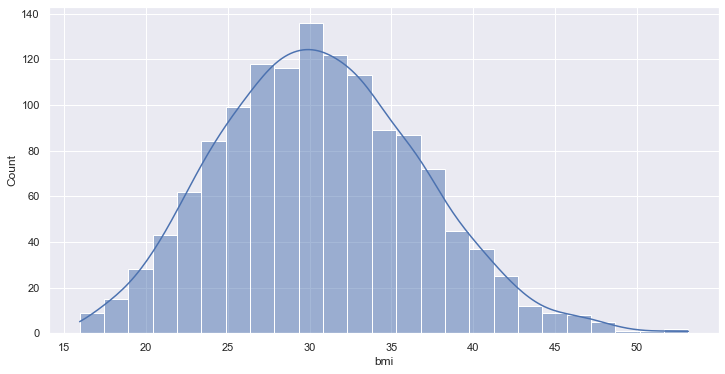

In [137]:
# Bmi(Vücut Kitle İndeksi)’nin dağılımını inceleyiniz.

plt.figure(figsize=(12,6))
sns.set_theme()
sns.histplot(df,x="bmi",kde=True);

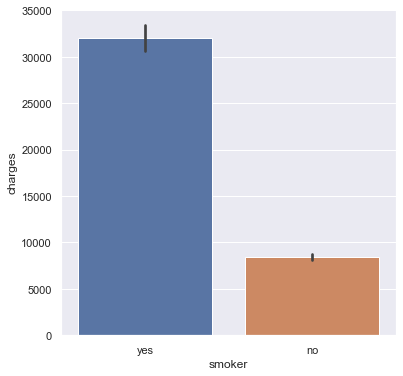

In [138]:
# “smoker” ile “charges” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(6,6))
sns.barplot(x="smoker",y="charges",data=df);

In [139]:
df[["smoker","charges"]].groupby(["smoker"]).mean()

,charges
smoker,
no,8434.268298
yes,32050.231832


Sigara içenlerin içmeyenlere oranla sağlık harcamalarının çok fazla olduğu açıkça görülüyor. Sigara içenlerin ortalama harcaması 32050 iken içmeyenlerin harcaması 8434'tür. 

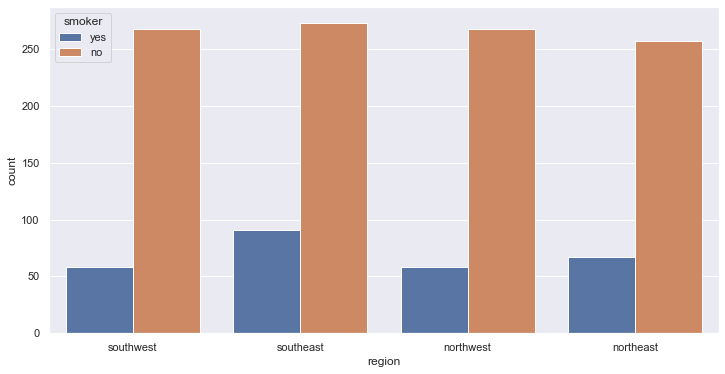

In [140]:
# “smoker” (Sigara tüketen) ile “region”(Bölge) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.countplot(x="region",data=df,hue="smoker");

In [141]:
def relationshipPlot(data, x_var, y_var, hue):
  g = sns.relplot(x=x_var, 
            y=y_var, 
            hue=hue, 
            data=data,
            sizes=(40, 400), 
            alpha=.7, 
            palette='muted', 
            height=8, 
            aspect=8/8)
                        
  plt.subplots_adjust(top=0.85)
  plt.setp(g._legend.get_texts(), fontsize='16')

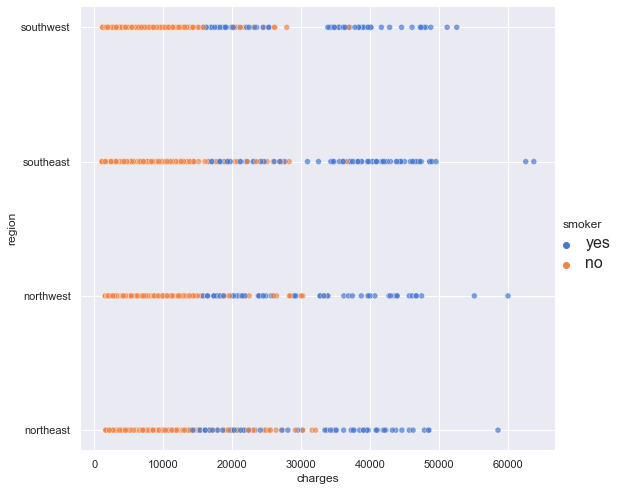

In [142]:
relationshipPlot(df, df.charges, df.region, df.smoker)

In [143]:
df.groupby(["region","smoker"]).agg(Smoker_Count=("region","count")).reset_index()

,region,smoker,Smoker_Count
0,northeast,no,257
1,northeast,yes,67
2,northwest,no,267
3,northwest,yes,58
4,southeast,no,273
5,southeast,yes,91
6,southwest,no,267
7,southwest,yes,58


In [144]:
# Pie

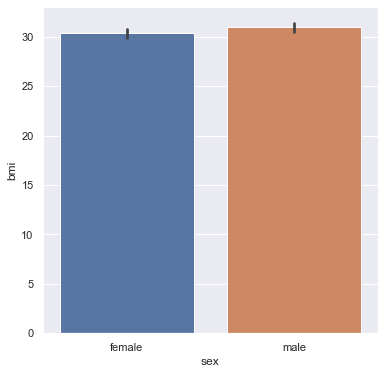

In [145]:
# “bmi” ile “sex”(Cinsiyet) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(6,6))
sns.barplot(x="sex",y="bmi",data=df);

Vücut kitle endeksi ile cinsiyet arasında bir bağlantı bulunmamaktadır.

In [146]:
# En çok “children”’a sahip “region”’ı bulunuz.

df.groupby(["region"]).agg(Children=("region","count")).sort_values(by="Children",ascending=False)

,Children
region,
southeast,364
northwest,325
southwest,325
northeast,324


En fazla çocuk 364 çocuk ile güneydoğu bölgesinde bulunmaktadır.

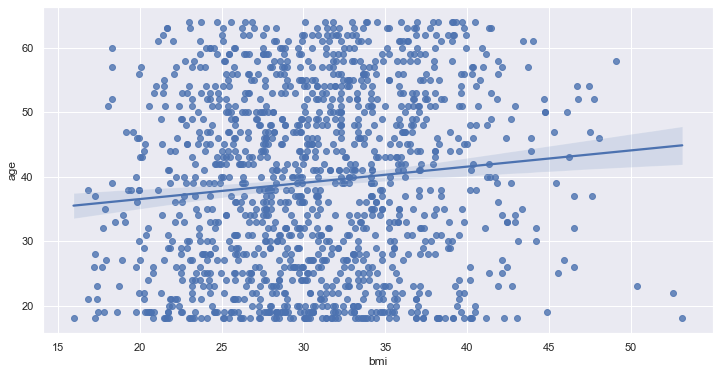

In [147]:
# “Age” ile “bmi” arasındaki ilişkiyi inceleyiniz.
plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="age",data=df);

Yaş ile vücut kitle endeksi arasında doğru orantı olduğu görülmektedir.

<Figure size 864x432 with 0 Axes>

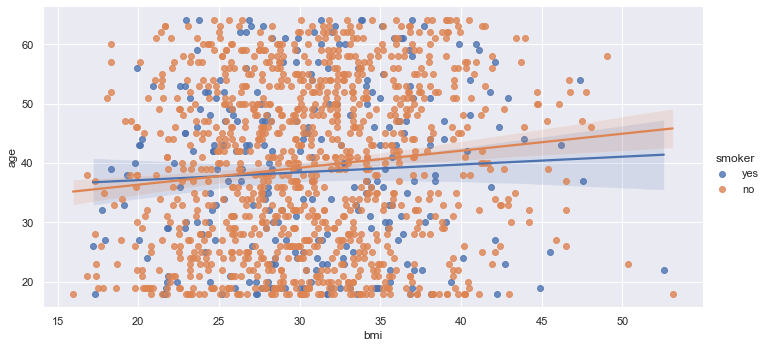

In [148]:
plt.figure(figsize=(12,6))
sns.lmplot(x="bmi",y="age",hue="smoker",data=df,aspect=2);

Sigara içmeyenlerin, sigara içenlere oranla vücut kitle endekslerinin yaş ile beraber daha fazla arttığı görülmektedir.

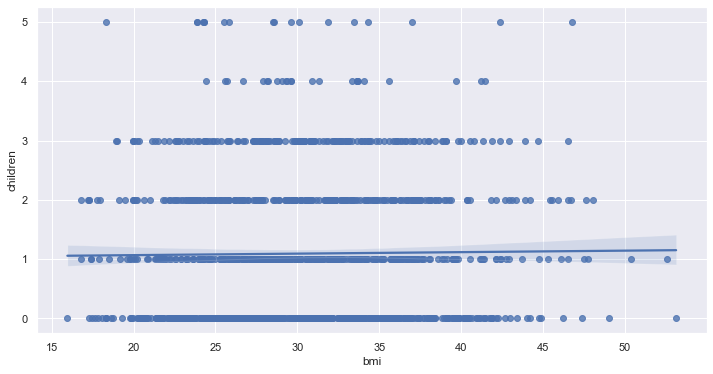

In [149]:
# “bmi” ile “children” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="children",data=df);

Çocuk sayısıyla vücut kitle endeksi arasında bir ilişki bulunmamaktadır.

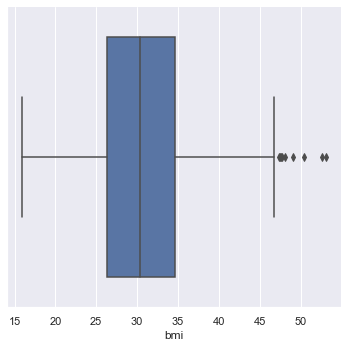

In [150]:
# “bmi” değişkeninde outlier var mıdır? İnceleyiniz.

sns.catplot(x="bmi",data=df,kind="box");

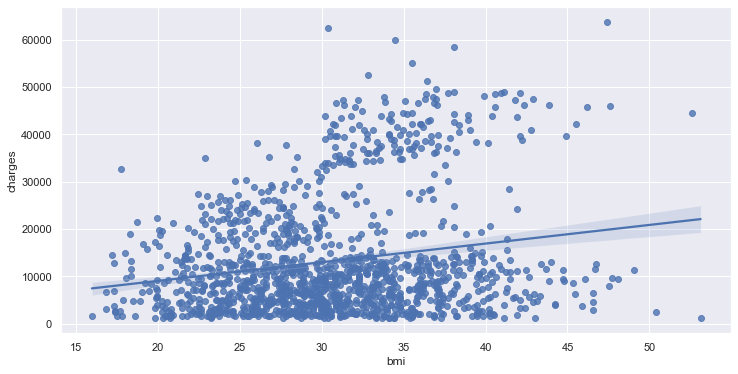

In [151]:
# “bmi” ile “charges” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="charges",data=df);

Vücut kitle endeksi arttıkça sağlık harcamalarında da artış olduğu gözlemlenmektedir.

<Figure size 864x432 with 0 Axes>

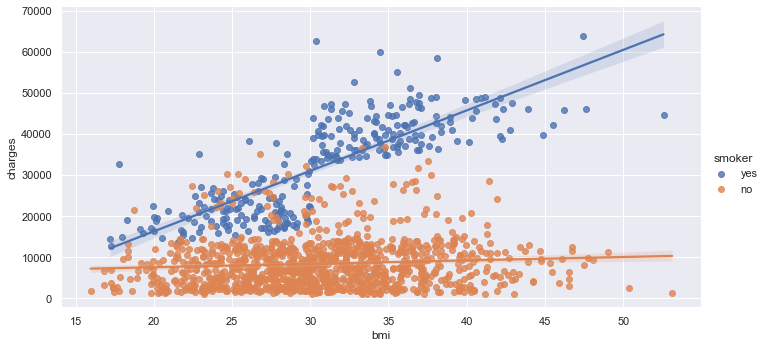

In [152]:
plt.figure(figsize=(12,6))
sns.lmplot(x="bmi",y="charges",hue="smoker",data=df,aspect=2);

Vücut kitle endeksi artışına orantılı olarak sigara içenlerin sağlık harcamaları çok daha fazla artmaktadır.

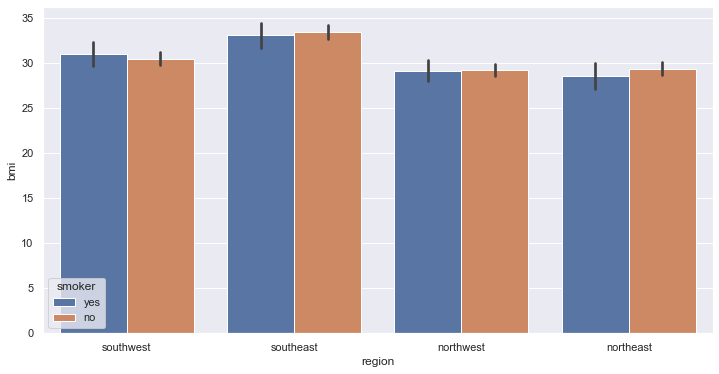

In [153]:
# “region”, “smoker” ve “bmi” arasındaki ilişkiyi bar plot kullanarak inceleyiniz.

plt.figure(figsize=(12,6))
sns.barplot(x="region", y="bmi", hue="smoker", data=df);

Veri Ön İşleme Yapılması

In [154]:

df.loc[df["sex"]=="male","sex"] = 0
df.loc[df["sex"]=="female","sex"] = 1

df.loc[df["smoker"]=="no","smoker"] = 0
df.loc[df["smoker"]=="yes","smoker"] = 1

df.loc[df["region"]=="northwest","region"] = 0
df.loc[df["region"]=="northeast","region"] = 1
df.loc[df["region"]=="southwest","region"] = 2
df.loc[df["region"]=="southeast","region"] = 3


In [155]:

df = df.astype({"sex":"category"})
df = df.astype({"smoker":"category"})
df = df.astype({"region":"category"})


In [156]:
def ageRange(age):
    if age<3:
        return 0
    elif age >=3 and age <17:
        return 1
    elif age >=18 and age <30:
        return 2
    elif age >=30 and age <50:
        return 3
    else:
        return 4

In [157]:
def bmiRange(bmi):
    if bmi<18.5:
        return 0
    elif bmi >=18.5 and bmi <24.9:
        return 1
    elif bmi >=24.9 and bmi <29.9:
        return 2
    elif bmi >=29.9 and bmi <39.9:
        return 3
    else:
        return 4

In [158]:
def chargesRange(charge,df):
    q1 = df.quantile(0.25)
    median = df.quantile(0.5)
    q3 = df.quantile(0.75)

    if charge < q1:
        return 0
    elif charge >= q1 and charge < median:
        return 1
    elif charge >= median and charge < q3:
        return 2
    else:
        return 3

In [159]:
df["age range"] = df["age"].apply(lambda x:ageRange(x))
df["bmi range"] = df["bmi"].apply(lambda x:bmiRange(x))
df["charges range"] = df["charges"].apply(lambda x:chargesRange(x,df["charges"]))

Outlier Detection

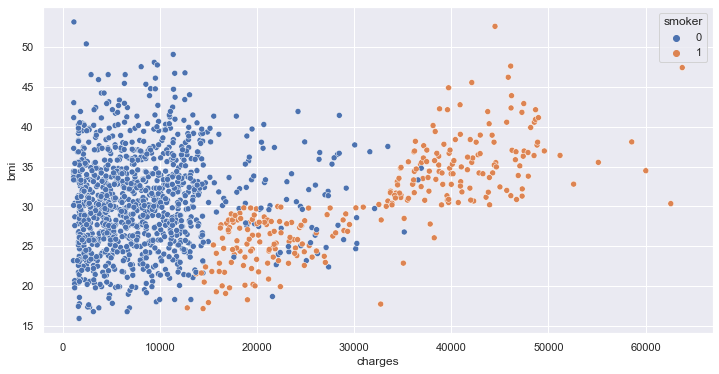

In [160]:
plt.figure(figsize=(12,6))
sns.set_theme()
sns.scatterplot(data = df,x="charges",y="bmi",hue="smoker");

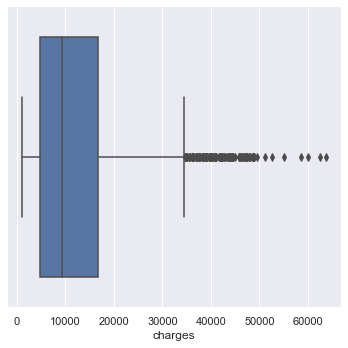

In [161]:
sns.catplot(x="charges",data=df,kind="box");

In [162]:
chargesdf = df[["charges","smoker"]].groupby(["smoker"])
chargesdf.describe()

charges                                                        \
         count          mean           std         min           25%   
smoker                                                                 
0       1064.0   8434.268298   5993.781819   1121.8739   3986.438700   
1        274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                                                
                50%           75%          max  
smoker                                          
0        7345.40530  11362.887050  36910.60803  
1       34456.34845  41019.207275  63770.42801

In [163]:
nonSmokerQ1 = df.loc[df["smoker"]==0]["charges"].quantile(0.25)
nonSmokerQ3 = df.loc[df["smoker"]==0]["charges"].quantile(0.75)

nonSmokerMinimum = nonSmokerQ1 - 1.5*(nonSmokerQ3-nonSmokerQ1)
nonSmokerMaxsimum = nonSmokerQ1 + 1.5*(nonSmokerQ3-nonSmokerQ1)


smokerQ1 = df.loc[df["smoker"]==1]["charges"].quantile(0.25)
smokerQ3 = df.loc[df["smoker"]==1]["charges"].quantile(0.75)

SmokerMinimum = smokerQ1 - 1.5*(smokerQ3-smokerQ1)
SmokerMaxsimum = smokerQ1 + 1.5*(smokerQ3-smokerQ1)

In [164]:
nonSmokerOut = df[(df["smoker"]==0)&(df["charges"]<nonSmokerMinimum)|((df["smoker"]==0)&(df["charges"]>nonSmokerMaxsimum))].index
smokerOut = df[(df["smoker"]==1)&(df["charges"]<SmokerMinimum)|((df["smoker"]==1)&(df["charges"]>SmokerMaxsimum))].index

In [165]:
df.drop(index=nonSmokerOut,inplace=True)
df.drop(index=smokerOut,inplace=True)

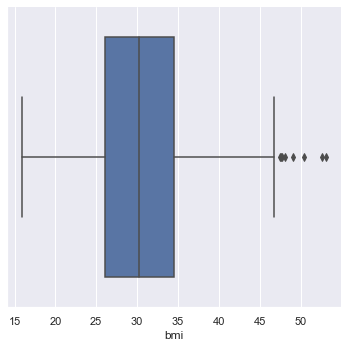

In [166]:
sns.catplot(x="bmi",data=df,kind="box");

In [167]:
chargesdf = df[["bmi","smoker"]].groupby(["smoker"])
chargesdf.describe()

bmi                                                            
        count       mean       std     min     25%    50%      75%    max
smoker                                                                   
0       974.0  30.565467  6.106633  15.960  26.205  30.21  34.3725  53.13
1       267.0  30.558184  6.278518  17.195  25.965  30.21  35.0250  52.58

In [168]:
bmiQ1 = df["bmi"].quantile(0.25)
bmiQ3 = df["bmi"].quantile(0.75)

bmiMinimum = bmiQ1 - 1.5*(bmiQ3-bmiQ1)
bmiMaximum = bmiQ1 + 1.5*(bmiQ3-bmiQ1)

In [169]:
bmiOut = df[(df["bmi"]<bmiMinimum)|((df["bmi"]>bmiMaximum))].index

In [170]:
df.drop(index=bmiOut,inplace=True)

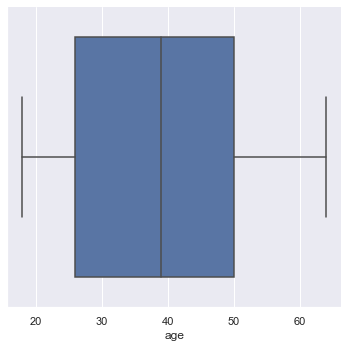

In [171]:
sns.catplot(x="age",data=df,kind="box");

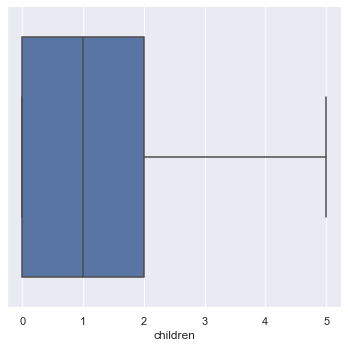

In [172]:
sns.catplot(x="children",data=df,kind="box");

Model Seçme

In [173]:
x = df.drop(["charges"],axis=1)
y = df["charges"]

In [174]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=200)

In [175]:
models = []

models.append(("Linear",LinearRegression()))
models.append(("Lasso",Lasso()))
models.append(("Ridge",Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandomForests', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))


In [176]:
modelsdf = pd.DataFrame({"Model":[],"Score":[],"R^2 Score":[],"MSE":[],"MAE":[],"MAPE":[],"RMSE":[]})
for name,model in models:
    mod = model.fit(X_train,Y_train)
    predictions= mod.predict(X_test)

    score = mod.score(x,y)
    r2Score = r2_score(Y_test,predictions)
    mse = mean_squared_error(Y_test,predictions)
    mae = mean_absolute_error(Y_test,predictions)
    mape = mean_absolute_percentage_error(Y_test,predictions)   
    rmse = np.sqrt(mean_squared_error(Y_test,predictions))


    dfAdder = pd.DataFrame({"Model":[name],"Score":[score],"R^2 Score":[r2Score],"MSE":[mse],"MAE":[mae],"MAPE":[mape],"RMSE":[rmse]})
    modelsdf = modelsdf.append(dfAdder)
    


C:\Users\Orhun\AppData\Local\Temp\ipykernel_32024\2700829184.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelsdf = modelsdf.append(dfAdder)
C:\Users\Orhun\AppData\Local\Temp\ipykernel_32024\2700829184.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelsdf = modelsdf.append(dfAdder)
C:\Users\Orhun\AppData\Local\Temp\ipykernel_32024\2700829184.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelsdf = modelsdf.append(dfAdder)
C:\Users\Orhun\AppData\Local\Temp\ipykernel_32024\2700829184.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelsdf = modelsdf.append(dfAdder)
C:\Users\Orhun\AppData\Local\Temp\ipykernel_

In [177]:
modelsdf.sort_values(by="Score", ascending=False)

,Model,Score,R^2 Score,MSE,MAE,MAPE,RMSE
0,CART,0.993229,0.962952,4.231731e+06,651.561140,0.049062,2057.117102
0,RandomForests,0.992927,0.973690,3.005215e+06,557.375342,0.045969,1733.555570
0,GradientBoosting,0.989132,0.971440,3.262154e+06,692.198484,0.076148,1806.143373
0,Ridge,0.859730,0.851026,1.701602e+07,3001.326640,0.407680,4125.048317
0,Lasso,0.859694,0.850397,1.708791e+07,3007.261555,0.408233,4133.752293
0,Linear,0.859685,0.850350,1.709326e+07,3008.339159,0.408457,4134.400174
0,KNN,0.762215,0.706109,3.356877e+07,2874.975653,0.206599,5793.856045
0,SVR,-0.089389,-0.067196,1.218969e+08,7120.005903,1.028666,11040.694707


6. Hiper-parametre Optimizasyonu

In [178]:
automl = AutoML()

automl.fit(X_train, Y_train, task="regression",time_budget=60)

[flaml.automl: 08-28 20:45:23] {2068} INFO - task = regression
[flaml.automl: 08-28 20:45:23] {2070} INFO - Data split method: uniform
[flaml.automl: 08-28 20:45:23] {2074} INFO - Evaluation method: cv
[flaml.automl: 08-28 20:45:23] {2155} INFO - Minimizing error metric: 1-r2
[flaml.automl: 08-28 20:45:23] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 08-28 20:45:23] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-28 20:45:23] {2616} INFO - Estimated sufficient time budget=490s. Estimated necessary time budget=3s.
[flaml.automl: 08-28 20:45:23] {2663} INFO -  at 0.1s,	estimator lgbm's best error=0.4715,	best estimator lgbm's best error=0.4715
[flaml.automl: 08-28 20:45:23] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-28 20:45:23] {2663} INFO -  at 0.1s,	estimator lgbm's best error=0.4715,	best estimator lgbm's best error=0.4715
[flaml.automl: 08-28 20:45:23] {2501} INFO - 

In [179]:
model = LGBMRegressor(**automl.best_config)
model.fit(X_train,Y_train)

LGBMRegressor(colsample_bytree=0.7886214204493228,
              learning_rate=0.09433905667060005, log_max_bin=10,
              min_child_samples=17, n_estimators=73, num_leaves=25,
              reg_alpha=13.232327485540994, reg_lambda=0.8111667619410736)

In [180]:
model = LGBMRegressor(colsample_bytree=0.7886214204493228,
              learning_rate=0.09433905667060005, log_max_bin=10,
              min_child_samples=17, n_estimators=73, num_leaves=25,
              reg_alpha=13.232327485540994, reg_lambda=0.8111667619410736).fit(X_train,Y_train)
predictions = model.predict(X_test)

In [181]:
score = model.score(x,y)
r2Score = r2_score(Y_test,predictions)
mse = mean_squared_error(Y_test,predictions)
mae = mean_absolute_error(Y_test,predictions)
mape = mean_absolute_percentage_error(Y_test,predictions)   
rmse = np.sqrt(mean_squared_error(Y_test,predictions))


result_df = pd.DataFrame({"Model":["LGBMRegressor"],"Score":[score],"R^2 Score":[r2Score],"MSE":[mse],"MAE":[mae],"MAPE":[mape],"RMSE":[rmse]})
modelsdf = modelsdf.append(result_df)

C:\Users\Orhun\AppData\Local\Temp\ipykernel_32024\16315941.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelsdf = modelsdf.append(result_df)


In [182]:
modelsdf.sort_values(by="Score", ascending=False)

,Model,Score,R^2 Score,MSE,MAE,MAPE,RMSE
0,CART,0.993229,0.962952,4.231731e+06,651.561140,0.049062,2057.117102
0,RandomForests,0.992927,0.973690,3.005215e+06,557.375342,0.045969,1733.555570
0,LGBMRegressor,0.989413,0.972149,3.181206e+06,588.722888,0.050142,1783.593677
0,GradientBoosting,0.989132,0.971440,3.262154e+06,692.198484,0.076148,1806.143373
0,Ridge,0.859730,0.851026,1.701602e+07,3001.326640,0.407680,4125.048317
0,Lasso,0.859694,0.850397,1.708791e+07,3007.261555,0.408233,4133.752293
0,Linear,0.859685,0.850350,1.709326e+07,3008.339159,0.408457,4134.400174
0,KNN,0.762215,0.706109,3.356877e+07,2874.975653,0.206599,5793.856045
0,SVR,-0.089389,-0.067196,1.218969e+08,7120.005903,1.028666,11040.694707


In [183]:

rf = RandomForestRegressor()

print(rf.get_params().keys())

params_rf = {"n_estimators" : [100, 200, 500, 1000],
              "bootstrap" : [True, False],
              "max_features" : [2, 3, 4, 5],
              "min_samples_leaf": [1, 2, 4],
              "min_samples_split": [2, 5, 7, 10],
              "random_state":[4]}

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=4, verbose=2, n_jobs = -1)
grid_rf.fit(X=X_train, y=Y_train)


dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Fitting 4 folds for each of 384 candidates, totalling 1536 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7, 10],
                         'n_estimators': [100, 200, 500, 1000],
                         'random_state': [4]},
             verbose=2)

In [184]:
predictions = grid_rf.predict(X_test)

In [185]:
r2Score = r2_score(Y_test,predictions)

In [186]:
score = model.score(x,y)
r2Score = r2_score(Y_test,predictions)
mse = mean_squared_error(Y_test,predictions)
mae = mean_absolute_error(Y_test,predictions)
mape = mean_absolute_percentage_error(Y_test,predictions)   
rmse = np.sqrt(mean_squared_error(Y_test,predictions))


result_df = pd.DataFrame({"Model":["RandomForests"],"Score":[score],"R^2 Score":[r2Score],"MSE":[mse],"MAE":[mae],"MAPE":[mape],"RMSE":[rmse]})


In [187]:
r2Score = r2_score(Y_test,predictions)
r2Score

0.9747050842656241